In [32]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import umap

In [33]:
# set default style of figures
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [96]:
#Load the data set
total_emissions = pd.read_csv('Emissions_AllAgriculture.csv', sep=',', encoding = 'latin-1')
total_emissions.columns = ('domain_code', 'domain', 'area_code','area', 'element_code','element','item_code', 'item','year_code','year','unit','value','flag', 'flag_description','note')
#total_emissions.set_index(['area','year'], inplace = True)
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1962,1962,gigagrams,5151.5228,A,"Aggregate, may include official, semi-official...",NaN


In [8]:
#Let's start to get an idea of the data
#First let's look at global emissions evolution per year 
total_per_year = total_emissions.groupby('year').sum()
total_per_year.head(2)

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1961,171113,10000473,7000191,2712063,3.005584e+06,0.0
1962,171113,10000473,7000191,2713446,3.069126e+06,0.0


In [138]:
fert_emissions = total_emissions.query("item == 'Synthetic Fertilizers'")
fert_emissions = fert_emissions.groupby('year').sum()
fert_emissions.head()

#emissions_2017 = total_emissions.query('year == 2017').groupby('area').sum()
#emissions_2017.head()

,area_code,element_code,item_code,year_code,value,note,Value,Year,normalized_value
year,,,,,,,,,
1961,21727,1272656,890736,345136,78306.1006,0.0,4792020.05,345136,11.686696
1962,21727,1272656,890736,345312,90023.8397,0.0,4804585.75,345312,13.202166
1963,21727,1272656,890736,345488,101554.4717,0.0,4817411.58,345488,13.882534
1964,21727,1272656,890736,345664,114402.4124,0.0,4829091.99,345664,14.616119
1965,21727,1272656,890736,345840,135091.7762,0.0,4847856.17,345840,15.385441


Text(0.5, 1.0, 'Global Agriculture Emissions from Synthetic Fertilizers\n')

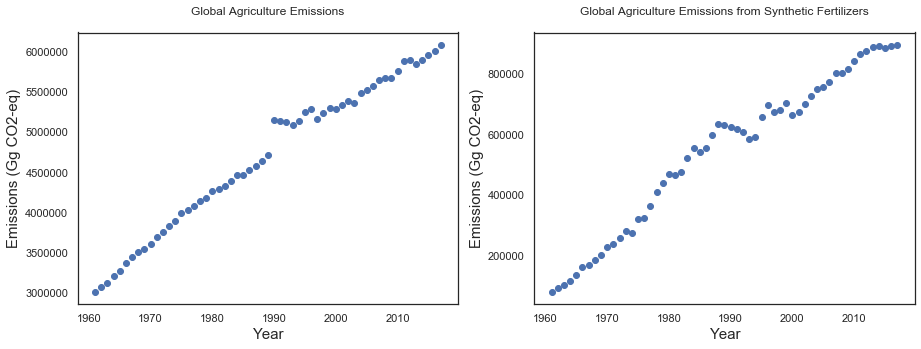

In [140]:
fig = plt.figure(figsize = (15, 5))

ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(total_per_year.index.values, total_per_year.value)
ax1.set_xlabel("Year", fontsize=15)
ax1.set_ylabel("Emissions (Gg CO2-eq)", fontsize=15)
ax1.set_title("Global Agriculture Emissions\n")

ax2 = fig.add_subplot(1,2,2)
plt.scatter(fert_emissions.index.values, fert_emissions.value)
ax2.set_xlabel("Year", fontsize=15)
ax2.set_ylabel("Emissions (Gg CO2-eq)", fontsize=15)
ax2.set_title("Global Agriculture Emissions from Synthetic Fertilizers\n")

We can see that there is a weird jump roughly around the year 1990. Let's figure out why that is:

In [10]:
#First look for the exact year where the jump occurs
total_per_year.loc[1988:1992]

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1988,173018,10108938,7076127,2779224,4.642316e+06,0.0
1989,173018,10108938,7076127,2780622,4.717353e+06,0.0
1990,211837,12365010,8814324,3402900,5.146297e+06,0.0
1991,211170,12336086,8794098,3396646,5.140631e+06,0.0
1992,230556,13493046,9619349,3717072,5.125552e+06,0.0


We see above that the discontinuity occurs between 1989 and 1990.

One possible reason for this could be that data for more areas became available in this year - let's check:

In [21]:
emissions_1989 = total_emissions.query("year == 1989").groupby('area').sum()
countries_1989 = len(emissions_1989.index)
print(countries_1989)

195


In [22]:
emissions_1990 = total_emissions.query("year == 1990").groupby('area').sum()
countries_1990 = len(emissions_1990.index)
print(countries_1990)

208


It seems that the discontinuity can be explained by the addition of many more areas starting in 1990 - this will be kept in mind during further analysis of this dataset.

First we want to study the relationship between yield of crops and emissions. Is there a clear relationship between higher yields and high emissions?

In [89]:
total_area=pd.read_csv('LandUse.csv',sep=',',encoding='latin-1')
total_area_agriculture = total_area.query("Item == 'Agriculture'")
#total_area_agriculture.set_index(['Area','Year'], inplace = True)
total_area_agriculture.head(2)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
114,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1961,1961,1000 ha,37700.0,Fc,Calculated data
115,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1962,1962,1000 ha,37760.0,Fc,Calculated data


In [97]:
total_emissions = pd.merge(total_emissions, total_area_agriculture.loc[:,['Value', 'Area','Year']], left_on = ['area','year'], right_on = ['Area','Year'])
total_emissions.head(2)


,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961


In [98]:
total_emissions['normalized_value'] = total_emissions.value / total_emissions.Value
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,normalized_value
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.134068
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.009757


In [53]:
def emissions_class(x): 
    if x<low :
        return 0
    elif low<=x<medium:
        return 1
    else:
        return 2

In [54]:
def emissions_class2(x): 
    if x<low :
        return 'low'
    elif low<=x<medium:
        return 'medium'
    else:
        return 'high'

In [25]:
#load the yield dataset
total_yield=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
total_yield.head(5)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,ha,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,ha,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,ha,6000.0,F


In [122]:
grouped_yield = total_yield.query('`Element Code` == 5419').query('`Item Code` >1000')
grouped_yield = grouped_yield.groupby(['Item','Year']).sum()
grouped_yield.head()

Area Code  Item Code  Element Code  Year Code  \
Item                      Year                                                  
Cereals (Rice Milled Eqv) 1961     191204     345230       1029610     372590   
                          1962     191204     345230       1029610     372780   
                          1963     191204     345230       1029610     372970   
                          1964     191204     345230       1029610     373160   
                          1965     191204     345230       1029610     373350   

                                    Value  
Item                      Year             
Cereals (Rice Milled Eqv) 1961  2392177.0  
                          1962  2507171.0  
                          1963  2503413.0  
                          1964  2575254.0  
                          1965  2597561.0

In [147]:
grouped_yield.loc['Cereals (Rice Milled Eqv)'].head(2)

,Area Code,Item Code,Element Code,Year Code,Value
Year,,,,,
1961,191204,345230,1029610,372590,2392177.0
1962,191204,345230,1029610,372780,2507171.0


Let's start by looking at the most recent year we have, 2017:

In [99]:
emissions_2017 = total_emissions.query('year == 2017').groupby('area').sum()
emissions_2017.head()

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,normalized_value
area,,,,,,,,,,
Afghanistan,18,65079,45560,18153,18153,13820.7055,0.0,341190.00,18153,0.364566
Albania,30,72310,52319,20170,20170,2844.0246,0.0,11691.81,20170,2.432493
Algeria,36,65079,45560,18153,18153,11429.6363,0.0,372015.00,18153,0.276512
American Samoa,30,43386,30375,12102,12102,4.5878,0.0,29.40,12102,0.936286
Andorra,6,7231,5067,2017,2017,0.0000,0.0,18.82,2017,0.000000


area_code            1200.000000
element_code        43386.000000
item_code           30370.000000
year_code           12102.000000
year                12102.000000
value                 166.181300
note                    0.000000
Value                   3.960000
Year                12102.000000
normalized_value      251.789848
Name: Singapore, dtype: float64

In [100]:
low = np.percentile(emissions_2017.normalized_value, 33.0)
medium = np.percentile(emissions_2017.normalized_value, 66.0)

In [44]:
grouped_yield_2017=(total_yield.query('`Element Code` == 5419') #by yield
        .query('`Year Code` == 2017') 
        .query('`Item Code` >1000') #grouped crops
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0)
        .reset_index()
          )
grouped_yield_2017.head()

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,19781.0,20247.0,86994.0,13565.0,85322.0,7137.0,159794.0,13724.0,95604.0
1,Africa,15440.0,16433.0,111661.0,14169.0,88601.0,7844.0,82971.0,5400.0,84747.0
2,Albania,48130.0,48130.0,257019.0,54934.0,215197.0,11834.0,251110.0,46849.0,280971.0
3,Algeria,9907.0,9907.0,194569.0,7480.0,109876.0,10670.0,309795.0,12364.0,221787.0
4,American Samoa,0.0,0.0,0.0,0.0,41982.0,0.0,38151.0,0.0,37005.0


In [45]:
yield_2017 = grouped_yield_2017.drop('Area',axis=1).values

#Normalization 
from sklearn import preprocessing

x = yield_2017
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
yield_2017 = pd.DataFrame(x_scaled)

In [104]:
reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(yield_2017)
embedding2=pd.DataFrame(embedding)
embedding2=pd.merge(embedding2,grouped_yield_2017['Area'], left_index=True, right_index=True)
embedding2=pd.merge(embedding2,emissions_2017.loc[:,['normalized_value']],left_on='Area',right_index = True)
embedding2['emissions_class']=embedding2.normalized_value.apply(emissions_class)
embedding2['emissions_class2']=embedding2.normalized_value.apply(emissions_class2)
embedding2.head()

,0,1,Area,normalized_value,emissions_class,emissions_class2
0,-0.646101,-4.375236,Afghanistan,0.364566,0,low
2,-3.140258,-1.871441,Albania,2.432493,2,high
3,-2.938607,-3.637467,Algeria,0.276512,0,low
4,2.520153,-5.016586,American Samoa,0.936286,0,low
6,-0.516268,-2.151231,Angola,0.583375,0,low


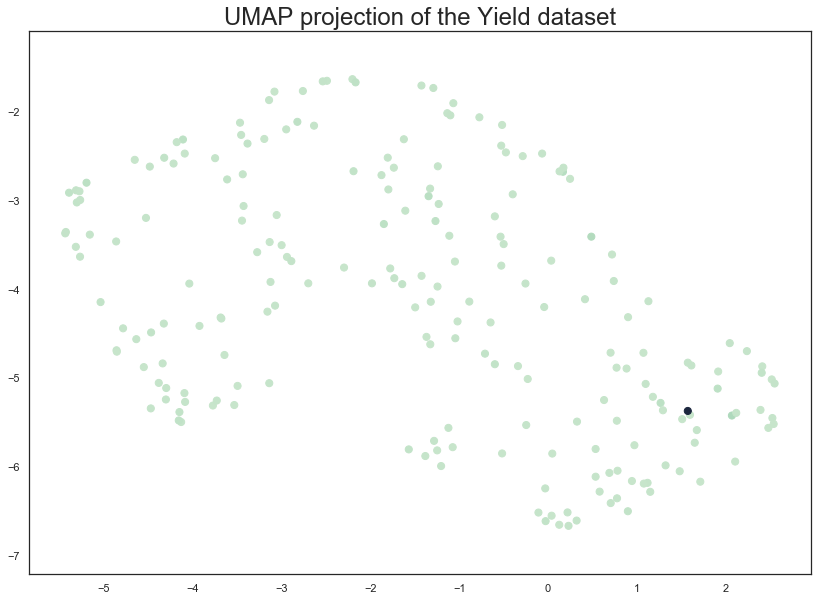

In [106]:
colors = ["green", "blue", "red"]
clarity_ranking = embedding2.normalized_value
cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2[1], c=clarity_ranking, s=50, cmap=cmap)
#plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.ferti_class.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset', fontsize=24);

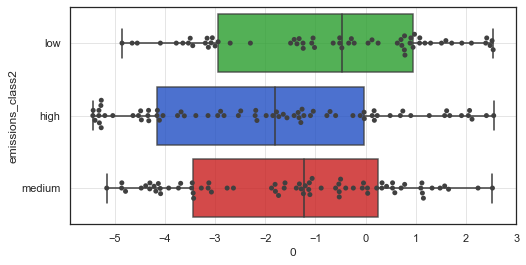

In [107]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='emissions_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='emissions_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

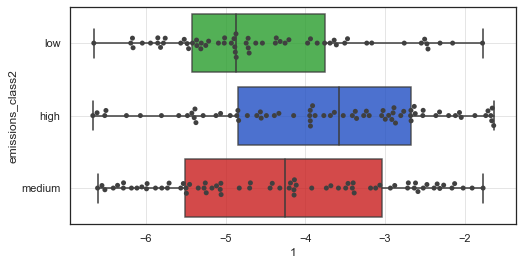

In [109]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))
#sns.palplot(sns.cubehelix_palette(3))
colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2[1], y='emissions_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[1], y='emissions_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

In [130]:
fert_emissions_2017 = total_emissions.query("item == 'Synthetic Fertilizers'").query('year == 2017').groupby('area').sum()
fert_emissions_2017.head(5)

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,normalized_value
area,,,,,,,,,,
Afghanistan,2,7231,5061,2017,2017,908.6579,0.0,37910.000,2017,0.023969
Albania,3,7231,5061,2017,2017,252.9246,0.0,1169.181,2017,0.216326
Algeria,4,7231,5061,2017,2017,453.1159,0.0,41335.000,2017,0.010962
Angola,7,7231,5061,2017,2017,172.4345,0.0,59215.000,2017,0.002912
Antigua and Barbuda,8,7231,5061,2017,2017,0.0580,0.0,9.000,2017,0.006444


In [131]:
low = np.percentile(fert_emissions_2017.normalized_value, 33.0)
medium = np.percentile(fert_emissions_2017.normalized_value, 66.0)

In [149]:
reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(yield_2017)
embedding2=pd.DataFrame(embedding)
embedding2=pd.merge(embedding2,grouped_yield_2017['Area'], left_index=True, right_index=True)
embedding2=pd.merge(embedding2,fert_emissions_2017.loc[:,['normalized_value']],left_on='Area',right_index = True)
embedding2['emissions_class']=embedding2.normalized_value.apply(emissions_class)
embedding2['emissions_class2']=embedding2.normalized_value.apply(emissions_class2)
embedding2.head()

,0,1,Area,normalized_value,emissions_class,emissions_class2
0,-0.646101,-4.375236,Afghanistan,0.023969,0,low
2,-3.140258,-1.871441,Albania,0.216326,1,medium
3,-2.938607,-3.637467,Algeria,0.010962,0,low
6,-0.516268,-2.151231,Angola,0.002912,0,low
7,1.614990,-4.859566,Antigua and Barbuda,0.006444,0,low


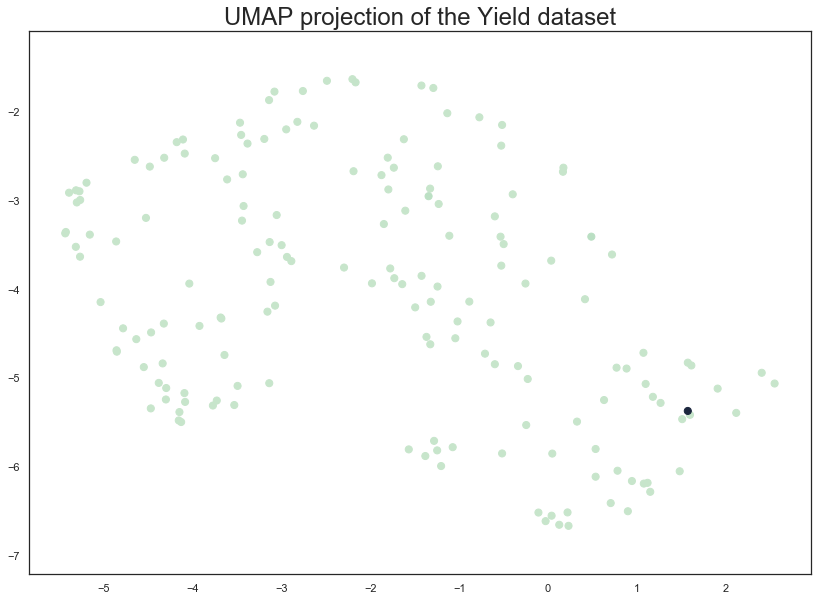

In [134]:
colors = ["green", "blue", "red"]
clarity_ranking = embedding2.normalized_value
cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2[1], c=clarity_ranking, s=50, cmap=cmap)
#plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.ferti_class.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset', fontsize=24);

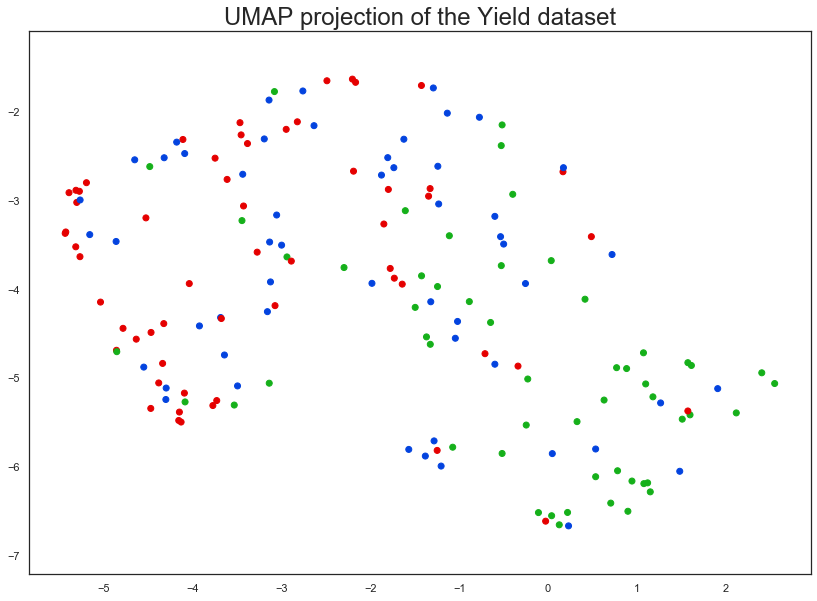

In [150]:
plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.emissions_class.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset', fontsize=24);

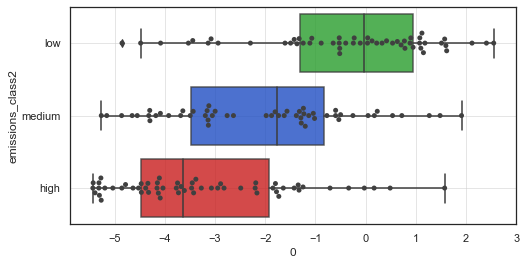

In [135]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='emissions_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='emissions_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

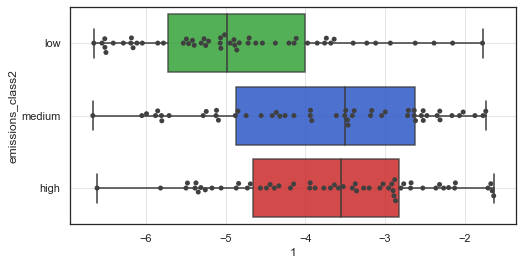

In [136]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))
#sns.palplot(sns.cubehelix_palette(3))
colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2[1], y='emissions_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[1], y='emissions_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

Looking at the plots above, we see that considering fertilizer emissions, there is a notable difference betweem the low, medium and high emissions categories when compared to the reduced dimensionality x value, and a notable difference between the low and the medium/high emissions categories when compared to the reduced dimensionality y value. 

The next step is to see if we can see anything interesting from these differences. For example, what causes the differences between groups? Which places have similar yield characteristics but drastically different emissions? Why might that be?

In [172]:
embedding2.query("emissions_class2 == 'low'")

,0,1,Area,normalized_value,emissions_class,emissions_class2
0,-0.646101,-4.375236,Afghanistan,0.023969,0,low
3,-2.938607,-3.637467,Algeria,0.010962,0,low
6,-0.516268,-2.151231,Angola,0.002912,0,low
7,1.614990,-4.859566,Antigua and Barbuda,0.006444,0,low
11,-3.444949,-3.228420,Australia,0.017874,0,low
14,-3.138125,-5.059040,Azerbaijan,0.011714,0,low
22,-0.885398,-4.140440,Benin,0.000075,0,low
24,-1.072509,-5.779690,Bhutan,0.009855,0,low
25,-0.227577,-5.011934,Bolivia (Plurinational State of),0.002448,0,low
27,1.511834,-5.463999,Botswana,0.005281,0,low


For example, above, we can see that Australia has synthetic fertilizer emissions in the low range, but has yield characteristics more similar to that of countries with medium to high emissions.

In [167]:
embedding2.query("emissions_class2 == 'high'")

,0,1,Area,normalized_value,emissions_class,emissions_class2
9,-3.072784,-4.185871,Armenia,0.346791,2,high
13,-4.526394,-3.197867,Austria,0.278032,2,high
15,-2.947220,-2.201047,Bahamas,0.305657,2,high
17,-1.847612,-3.266868,Bangladesh,0.871482,2,high
18,-4.149526,-5.384149,Barbados,0.349820,2,high
19,-4.338513,-4.836486,Belarus,0.308874,2,high
20,-5.392473,-2.914146,Belgium,0.814467,2,high
21,-1.326886,-2.867899,Belize,0.509569,2,high
23,0.169105,-2.678383,Bermuda,0.518000,2,high
31,-4.471860,-5.343098,Bulgaria,0.429365,2,high


And here, we can see that Trinidad and Tobago has synthetic fertilizer emissions in the high range, but has yield characteristics more similar to that of countries with low emissions.

We can also see some outliers with much higher emissions than the other countries in the high range - Hong Kong, Qatar, and in particular Singapore. 